# Tyche Example for Simple Electrolysis

## Set up.

### One only needs to execute the following line once, in order to make sure recent enough packages are installed.

In [1]:
#!pip install 'numpy>=1.17.2' 'pandas>=0.25.1'

### Import packages.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../../src"))

In [2]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb

# The `tyche` package is located at <https://github.com/NREL/portfolio/tree/master/production-function/framework/src/tyche/>.
import tyche             as ty

from copy import deepcopy

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs(".")

In [5]:
investments = ty.Investments(".")

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Examine the data.

### The `functions` table specifies where the Python code for each technology resides.

In [7]:
designs.functions

,Style,Module,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Simple electrolysis,numpy,simple_electrolysis,capital_cost,fixed_cost,production,metrics,


Right now, only the style `numpy` is supported.

### The `indices` table defines the subscripts for variables.

In [8]:
designs.indices

Offset               Description  \
Technology          Type    Index                                           
Simple electrolysis Capital Catalyst          0                  Catalyst   
                    Fixed   Rent              0                      Rent   
                    Input   Electricity       1               Electricity   
                            Water             0                     Water   
                    Metric  Cost              0                      Cost   
                            GHG               2  Greenhouse gas emissions   
                            Jobs              1                      Jobs   
                    Output  Hydrogen          1                  Hydrogen   
                            Oxygen            0                    Oxygen   

                                        Notes  
Technology          Type    Index              
Simple electrolysis Capital Catalyst           
                    Fixed   Rent               
                    Input   Electricity        
                            Water              
                    Metric  Cost               
                            GHG                
                            Jobs               
                    Output  Hydrogen           
                            Oxygen

### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [9]:
designs.designs

Value  \
Technology          Scenario                          Variable          Index                                                       
Simple electrolysis Base Electrolysis                 Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity                                          0.85   
                                                                        Water                                                0.95   
                                                      Input price       Electricity                                      3.33E-05   
                                                                        Water                                            4.80E-03   
                                                      Lifetime          Catalyst                                                3   
                                                      Output efficiency Hydrogen                                              0.9   
                                                                        Oxygen                                                0.9   
                                                      Output price      Hydrogen                                         1.00E-02   
                                                                        Oxygen                                           3.00E-03   
                                                      Scale             NaN                                                  6650   
                    Fast Progress on Electrolysis     Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity  st.truncnorm(-3, 0.75, loc=0.97, scale=0.04)   
                                                                        Water           st.truncnorm(-3, 2, loc=0.97, scale=0.01)   
                                                      Input price       Electricity                                      3.33E-05   
                                                                        Water                                            4.80E-03   
                                                      Lifetime          Catalyst                                                3   
                                                      Output efficiency Hydrogen              st.beta(3, 2, loc=0.90, scale=0.03)   
                                                                        Oxygen                st.beta(3, 2, loc=0.90, scale=0.06)   
                                                      Output price      Hydrogen                                         1.00E-02   
                                                                        Oxygen                                           3.00E-03   
                                                      Scale             NaN                                                  6650   
                    Moderate Progress on Electrolysis Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity  st.truncnorm(-2, 1.75, loc=0.93, scale=0.04)   
                                                                        Water           st.truncnorm(-2, 3, loc=0.97, scale=0.01)   
                                                      Input price       Electricity                                      3.33E-05   
 

### The `parameters` table contains additional techno-economic parameters for each technology.

In [10]:
designs.parameters

Offset  \
Technology          Scenario                          Parameter                                     
Simple electrolysis Base Electrolysis                 Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Fast Progress on Electrolysis     Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Moderate Progress on Electrolysis Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Slow Progress on Electrolysis     Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                   

### The `results` table specifies the units of measure for results of computations.

In [11]:
designs.results

Units Notes
Technology          Variable Index                    
Simple electrolysis Cost     Cost       USD/mole      
                    Metric   Cost        USD/gH2      
                             GHG       gCO2e/gH2      
                             Jobs        job/gH2      
                    Output   Hydrogen     g/mole      
                             Oxygen       g/mole

### The `tranches` table specifies multually exclusive possibilities for investments: only one `Tranch` may be selected for each `Cateogry`.

In [12]:
investments.tranches

Amount  \
Category         Tranche                 Scenario                                       
Electrolysis R&D High Electrolysis R&D   Fast Progress on Electrolysis      5000000.0   
                 Low Electrolysis R&D    Slow Progress on Electrolysis      1000000.0   
                 Medium Electrolysis R&D Moderate Progress on Electrolysis  2500000.0   
                 No Electrolysis R&D     Base Electrolysis                        0.0   

                                                                           Notes  
Category         Tranche                 Scenario                                 
Electrolysis R&D High Electrolysis R&D   Fast Progress on Electrolysis            
                 Low Electrolysis R&D    Slow Progress on Electrolysis            
                 Medium Electrolysis R&D Moderate Progress on Electrolysis        
                 No Electrolysis R&D     Base Electrolysis

### The `investments` table bundles a consistent set of tranches (one per category) into an overall investment.

In [13]:
investments.investments

,,,Notes
Investment,Category,Tranche,
High R&D Spending,Electrolysis R&D,High Electrolysis R&D,
Low R&D Spending,Electrolysis R&D,Low Electrolysis R&D,
Medium R&D Spending,Electrolysis R&D,Medium Electrolysis R&D,
No R&D Spending,Electrolysis R&D,No Electrolysis R&D,


## Evaluate the scenarios in the dataset.

In [14]:
scenario_results = designs.evaluate_scenarios(sample_count=50)

Evaluating Simple electrolysis


In [15]:
scenario_results.xs(1, level="Sample", drop_level=False)

Value  \
Technology          Scenario                          Sample Variable Index                 
Simple electrolysis Base Electrolysis                 1      Cost     Cost       0.183900   
                                                             Metric   Cost       0.102121   
                                                                      GHG       21.391959   
                                                                      Jobs       0.000083   
                                                             Output   Hydrogen   1.800796   
                                                                      Oxygen    14.406372   
                    Fast Progress on Electrolysis     1      Cost     Cost       0.182620   
                                                             Metric   Cost       0.099022   
                                                                      GHG       20.888069   
                                                                      Jobs       0.000081   
                                                             Output   Hydrogen   1.844238   
                                                                      Oxygen    15.269009   
                    Moderate Progress on Electrolysis 1      Cost     Cost       0.185276   
                                                             Metric   Cost       0.096942   
                                                                      GHG       20.156041   
                                                                      Jobs       0.000078   
                                                             Output   Hydrogen   1.911217   
                                                                      Oxygen    14.916348   
                    Slow Progress on Electrolysis     1      Cost     Cost       0.184079   
                                                             Metric   Cost       0.099980   
                                                                      GHG       20.923092   
                                                                      Jobs       0.000081   
                                                             Output   Hydrogen   1.841151   
                                                                      Oxygen    14.934507   

                                                                                    Units  
Technology          Scenario                          Sample Variable Index                
Simple electrolysis Base Electrolysis                 1      Cost     Cost       USD/mole  
                                                             Metric   Cost        USD/gH2  
                                                                      GHG       gCO2e/gH2  
                                                                      Jobs        job/gH2  
                                                             Output   Hydrogen     g/mole  
                                                                      Oxygen       g/mole  
                    Fast Progress on Electrolysis     1      Cost     Cost       USD/mole  
                                                             Metric   Cost        USD/gH2  
                                                                      GHG       gCO2e/gH2  
                                                                      Jobs        job/gH2  
                                                             Output   Hydrogen     g/mole  
                                                                      Oxygen       g/mole  
                    Moderate Progress on Electrolysis 1      Cost     Cost       USD/mole  
                                                             Metric   Cost        USD/gH2  
                                                                      GHG       gCO2e/gH2  
                                                                      Jobs        job/gH2  
         

### Save results.

In [16]:
#scenario_results.to_csv("example-scenario.csv")

### Plot GHG metric.

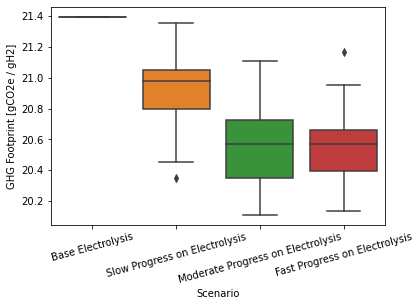

In [17]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "GHG"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="GHG Footprint [gCO2e / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot cost metric.

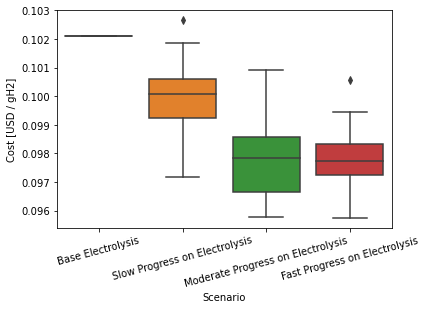

In [18]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "Cost"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="Cost [USD / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot employment metric.

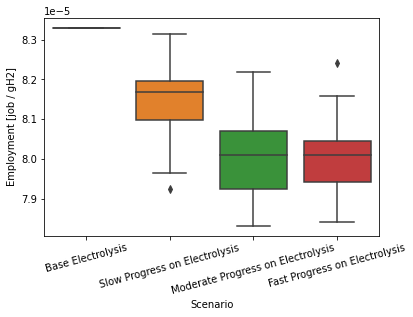

In [19]:
g = sb.boxplot(
    x="Scenario",
    y="Value",
    data=scenario_results.xs(
        ["Metric", "Jobs"],
        level=["Variable", "Index"]
    ).reset_index()[["Scenario", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="Employment [job / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

## Evaluate the investments in the dataset.

In [20]:
investment_results = investments.evaluate_investments(designs, sample_count=50)

Evaluating Simple electrolysis


### Costs of investments.

In [21]:
investment_results.amounts

,Amount
Investment,
High R&D Spending,5000000.0
Low R&D Spending,1000000.0
Medium R&D Spending,2500000.0
No R&D Spending,0.0


### Benefits of investments.

In [22]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment          Category         Tranche                 Scenario                          Sample Technology          Index              
No R&D Spending     Electrolysis R&D No Electrolysis R&D     Base Electrolysis                 1      Simple electrolysis Cost    0.102121   
                                                                                                                          GHG    21.391959   
                                                                                                                          Jobs    0.000083   
High R&D Spending   Electrolysis R&D High Electrolysis R&D   Fast Progress on Electrolysis     1      Simple electrolysis Cost    0.096655   
                                                                                                                          GHG    20.201519   
                                                                                                                          Jobs    0.000079   
Medium R&D Spending Electrolysis R&D Medium Electrolysis R&D Moderate Progress on Electrolysis 1      Simple electrolysis Cost    0.098166   
                                                                                                                          GHG    20.642890   
                                                                                                                          Jobs    0.000080   
Low R&D Spending    Electrolysis R&D Low Electrolysis R&D    Slow Progress on Electrolysis     1      Simple electrolysis Cost    0.099025   
                                                                                                                          GHG    20.924172   
                                                                                                                          Jobs    0.000081   

                                                                                                                                     Units  
Investment          Category         Tranche                 Scenario                          Sample Technology          Index             
No R&D Spending     Electrolysis R&D No Electrolysis R&D     Base Electrolysis                 1      Simple electrolysis Cost     USD/gH2  
                                                                                                                          GHG    gCO2e/gH2  
                                                                                                                          Jobs     job/gH2  
High R&D Spending   Electrolysis R&D High Electrolysis R&D   Fast Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                                                                          GHG    gCO2e/gH2  
                                                                                                                          Jobs     job/gH2  
Medium R&D Spending Electrolysis R&D Medium Electrolysis R&D Moderate Progress on Electrolysis 1      Simple electrolysis Cost     USD/gH2  
                                                                                                                          GHG    gCO2e/gH2  
                                                                                                                          Jobs     job/gH2  
Low R&D Spending    Electrolysis R&D Low Electrolysis R&D    Slow Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                                                                          GHG    gCO2e/gH2  
                                                                                                                          Jobs     job/gH2

In [23]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value      Units
Investment          Technology          Sample Index                      
No R&D Spending     Simple electrolysis 1      Cost    0.102121    USD/gH2
                                               GHG    21.391959  gCO2e/gH2
                                               Jobs    0.000083    job/gH2
High R&D Spending   Simple electrolysis 1      Cost    0.096655    USD/gH2
                                               GHG    20.201519  gCO2e/gH2
                                               Jobs    0.000079    job/gH2
Medium R&D Spending Simple electrolysis 1      Cost    0.098166    USD/gH2
                                               GHG    20.642890  gCO2e/gH2
                                               Jobs    0.000080    job/gH2
Low R&D Spending    Simple electrolysis 1      Cost    0.099025    USD/gH2
                                               GHG    20.924172  gCO2e/gH2
                                               Jobs    0.000081    job/gH2

### Save results.

In [24]:
#investment_results.amounts.to_csv("example-investment-amounts.csv")

In [25]:
#investment_results.metrics.to_csv("example-investment-metrics.csv")

### Plot GHG metric.

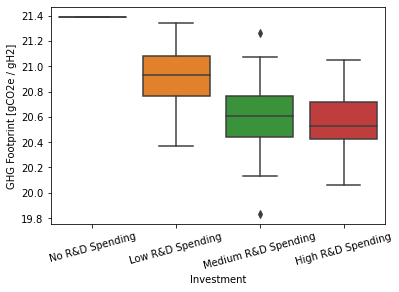

In [26]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "GHG",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="GHG Footprint [gCO2e / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot cost metric.

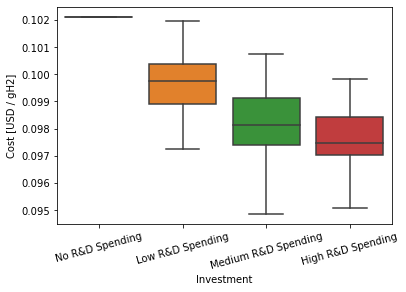

In [27]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Cost",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="Cost [USD / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

### Plot employment metric.

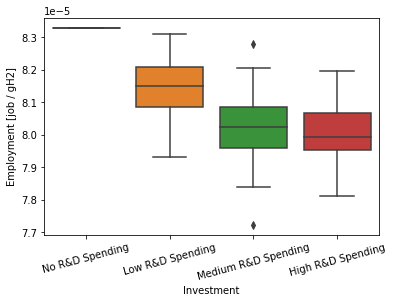

In [28]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Jobs",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="Employment [job / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=15);

## Sensitity analysis.

### Vary the four efficiencies in the design.

In [29]:
# Four variables are involved.
variables = [
    ("Input efficiency" , "Water"      ),
    ("Input efficiency" , "Electricity"),
    ("Output efficiency", "Oxygen"     ),
    ("Output efficiency", "Hydrogen"   ),
]

In [30]:
# Let efficiencies range from 0.75 to 0.975.
efficiencies = np.arange(0.750, 1.000, 0.025)
efficiencies

array([0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 ,
       0.975])

### Start from the base case.

In [31]:
base_design = designs.designs.xs("Base Electrolysis", level=1, drop_level=False)
base_design

Value  \
Technology          Scenario          Variable          Index                   
Simple electrolysis Base Electrolysis Input             Electricity       279   
                                                        Water           19.04   
                                      Input efficiency  Electricity      0.85   
                                                        Water            0.95   
                                      Input price       Electricity  3.33E-05   
                                                        Water        4.80E-03   
                                      Lifetime          Catalyst            3   
                                      Output efficiency Hydrogen          0.9   
                                                        Oxygen            0.9   
                                      Output price      Hydrogen     1.00E-02   
                                                        Oxygen       3.00E-03   
                                      Scale             NaN              6650   

                                                                        Units  \
Technology          Scenario          Variable          Index                   
Simple electrolysis Base Electrolysis Input             Electricity   kJ/mole   
                                                        Water          g/mole   
                                      Input efficiency  Electricity         1   
                                                        Water               1   
                                      Input price       Electricity    USD/kJ   
                                                        Water        USD/mole   
                                      Lifetime          Catalyst           yr   
                                      Output efficiency Hydrogen            1   
                                                        Oxygen              1   
                                      Output price      Hydrogen        USD/g   
                                                        Oxygen          USD/g   
                                      Scale             NaN           mole/yr   

                                                                                                     Notes  
Technology          Scenario          Variable          Index                                               
Simple electrolysis Base Electrolysis Input             Electricity                                         
                                                        Water                                               
                                      Input efficiency  Electricity                                         
                                                        Water                                               
                                      Input price       Electricity                                         
                                                        Water                                               
                                      Lifetime          Catalyst     Effective lifetime of Al-Ni catalyst.  
                                      Output efficiency Hydrogen                                            
                                                        Oxygen                                              
                                      Output price      Hydrogen                                            
                                                        Oxygen                                              
                                      Scale             NaN                Rough estimate for a 50W setup.

In [32]:
base_parameters = designs.parameters.xs("Base Electrolysis", level=1, drop_level=False)
base_parameters

Offset  \
Technology          Scenario          Parameter                                     
Simple electrolysis Base Electrolysis Electricity consumption                   3   
                                      GHG factor for electricity                9   
                                      GHG factor for water                      8   
                                      Hydrogen production                       1   
                                      Jobs                                      4   
                                      Oxygen production                         0   
                                      Reference capital cost for catalyst       6   
                                      Reference fixed cost for rent             7   
                                      Reference scale                           5   
                                      Water consumption                         2   

                                                                              Value  \
Technology          Scenario          Parameter                                       
Simple electrolysis Base Electrolysis Electricity consumption                   237   
                                      GHG factor for electricity              0.138   
                                      GHG factor for water                  0.00108   
                                      Hydrogen production                         2   
                                      Jobs                                 1.50E-04   
                                      Oxygen production                          16   
                                      Reference capital cost for catalyst      0.63   
                                      Reference fixed cost for rent            1000   
                                      Reference scale                          6650   
                                      Water consumption                       18.08   

                                                                              Units  \
Technology          Scenario          Parameter                                       
Simple electrolysis Base Electrolysis Electricity consumption                    kJ   
                                      GHG factor for electricity           gCO2e/kJ   
                                      GHG factor for water                  gCO2e/g   
                                      Hydrogen production                         g   
                                      Jobs                                 job/mole   
                                      Oxygen production                           g   
                                      Reference capital cost for catalyst       USD   
                                      Reference fixed cost for rent          USD/yr   
                                      Reference scale                       mole/yr   
                                      Water consumption                           g   

                                                                                                          Notes  
Technology          Scenario          Parameter                                                                  
Simple electrolysis Base Electrolysis Electricity consumption                                                    
                                      GHG factor for electricity                   based on 1 kWh = 0.5 kg CO2e  
                                      GHG factor for water                 based on 244,956 gallons = 1 Mg CO2e  
                                      Hydrogen production                                                        
                                      Jobs                                                                       
                                      Oxygen production                                                          
                                      Reference capi

### Generate the new scenarios and append them to the previous ones.

In [33]:
sensitivities = deepcopy(designs)
sensitivities.designs = sensitivities.designs[0:0]
sensitivities.parameters = sensitivities.parameters[0:0]

In [34]:
# Iterate over variables and efficiencies.
for variable, index in variables:
    for efficiency in efficiencies:

        # Name the scenario.
        scenario = "Let " + variable + " @ " + index + " = " + str(round(efficiency, 3))
        
        # Alter the base case.
        vary_design = base_design.rename(index={"Base Electrolysis" : scenario}, level=1)
        vary_design.loc[("Simple electrolysis", scenario, variable, index), "Value"] = efficiency
        
        # Keep the parameters the same.
        vary_parameters = base_parameters.rename(index={"Base Electrolysis" : scenario}, level=1)
        
        # Append the results to the existing table of scenarios.
        sensitivities.designs = sensitivities.designs.append(vary_design)
        sensitivities.parameters = sensitivities.parameters.append(vary_parameters)

#### Remember to compile the design, since we've added scenarios.

In [35]:
sensitivities.compile()

#### See how many rows there are in the tables now.

In [36]:
sensitivities.designs.shape

(480, 3)

In [37]:
sensitivities.parameters.shape

(400, 4)

In [38]:
sensitivities.designs

Value  \
Technology          Scenario                                 Variable          Index                   
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity       279   
                                                                               Water           19.04   
                                                             Input efficiency  Electricity      0.85   
                                                                               Water            0.75   
                                                             Input price       Electricity  3.33E-05   
...                                                                                              ...   
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen        0.975   
                                                                               Oxygen            0.9   
                                                             Output price      Hydrogen     1.00E-02   
                                                                               Oxygen       3.00E-03   
                                                             Scale             NaN              6650   

                                                                                              Units  \
Technology          Scenario                                 Variable          Index                  
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity  kJ/mole   
                                                                               Water         g/mole   
                                                             Input efficiency  Electricity        1   
                                                                               Water              1   
                                                             Input price       Electricity   USD/kJ   
...                                                                                             ...   
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen           1   
                                                                               Oxygen             1   
                                                             Output price      Hydrogen       USD/g   
                                                                               Oxygen         USD/g   
                                                             Scale             NaN          mole/yr   

                                                                                                                      Notes  
Technology          Scenario                                 Variable          Index                                         
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity                                   
                                                                               Water                                         
                                                             Input efficiency  Electricity                                   
                                                                               Water                                         
                                                             Input price       Electricity                                   
...                                                                                                                     ...  
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen                                      
                                                                               Oxygen                                        
                                                             Output price      Hydrogen                                      
                

### Compute the results.

In [39]:
results = sensitivities.evaluate_scenarios(1)
results

Evaluating Simple electrolysis


Value  \
Technology          Scenario                                  Sample Variable Index                 
Simple electrolysis Let Input efficiency @ Electricity = 0.75 1      Cost     Cost       0.190164   
                                                                     Metric   Cost       0.119657   
                                                                              GHG       24.239606   
                                                                              Jobs       0.000094   
                                                                     Output   Hydrogen   1.589241   
...                                                                                           ...   
                    Let Output efficiency @ Oxygen = 0.975    1      Metric   Cost       0.100121   
                                                                              GHG       21.391959   
                                                                              Jobs       0.000083   
                                                                     Output   Hydrogen   1.800796   
                                                                              Oxygen    15.606903   

                                                                                            Units  
Technology          Scenario                                  Sample Variable Index                
Simple electrolysis Let Input efficiency @ Electricity = 0.75 1      Cost     Cost       USD/mole  
                                                                     Metric   Cost        USD/gH2  
                                                                              GHG       gCO2e/gH2  
                                                                              Jobs        job/gH2  
                                                                     Output   Hydrogen     g/mole  
...                                                                                           ...  
                    Let Output efficiency @ Oxygen = 0.975    1      Metric   Cost        USD/gH2  
                                                                              GHG       gCO2e/gH2  
                                                                              Jobs        job/gH2  
                                                                     Output   Hydrogen     g/mole  
                                                                              Oxygen       g/mole  

[240 rows x 2 columns]

### Plot the cost results.

In [40]:
cost_results = results.xs("Cost", level="Variable").reset_index()[["Scenario", "Value"]]

In [41]:
cost_results[0:10]

,Scenario,Value
0,Let Input efficiency @ Electricity = 0.75,0.190164
1,Let Input efficiency @ Electricity = 0.775,0.188595
2,Let Input efficiency @ Electricity = 0.8,0.187026
3,Let Input efficiency @ Electricity = 0.825,0.185457
4,Let Input efficiency @ Electricity = 0.85,0.183900
5,Let Input efficiency @ Electricity = 0.875,0.184132
6,Let Input efficiency @ Electricity = 0.9,0.184364
7,Let Input efficiency @ Electricity = 0.925,0.184597
8,Let Input efficiency @ Electricity = 0.95,0.184829
9,Let Input efficiency @ Electricity = 0.975,0.185061


In [42]:
cost_results["Variable"  ] = cost_results["Scenario"].apply(lambda x: re.sub(r'^Let (.*) @ (.*) =.*$', '\\1[\\2]', x))
cost_results["Efficiency"] = cost_results["Scenario"].apply(lambda x: float(re.sub(r'^.*= (.*)$', '\\1', x)))
cost_results["Cost [USD/mole]"] = cost_results["Value"]

In [43]:
cost_results = cost_results[["Variable", "Efficiency", "Cost [USD/mole]"]]
cost_results[0:10]

,Variable,Efficiency,Cost [USD/mole]
0,Input efficiency[Electricity],0.750,0.190164
1,Input efficiency[Electricity],0.775,0.188595
2,Input efficiency[Electricity],0.800,0.187026
3,Input efficiency[Electricity],0.825,0.185457
4,Input efficiency[Electricity],0.850,0.183900
5,Input efficiency[Electricity],0.875,0.184132
6,Input efficiency[Electricity],0.900,0.184364
7,Input efficiency[Electricity],0.925,0.184597
8,Input efficiency[Electricity],0.950,0.184829
9,Input efficiency[Electricity],0.975,0.185061


<AxesSubplot:xlabel='Efficiency', ylabel='Cost [USD/mole]'>

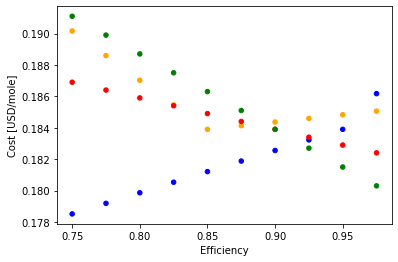

In [44]:
# Here is a really simple plot.
cost_results.plot(
    x="Efficiency",
    y="Cost [USD/mole]",
    c=cost_results["Variable"].apply(lambda v: {
        "Input efficiency[Water]"       : "blue"  ,
        "Input efficiency[Electricity]" : "orange",
        "Output efficiency[Oxygen]"     : "green" ,
        "Output efficiency[Hydrogen]"   : "red"   ,
    }[v]),
    kind="scatter"
)